In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle
from PIL import ImageFont
import visualkeras

In [2]:
import tensorflow_probability as tfp

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

cs_lo_k = {
            'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1
          }

br_ratio = {
            'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1
          }

cs_nmg = {
         'ttbar':393.30,
         'wmp'  :7.865*1e4,
         'wpwm' :74.96,
         'zwpm' :14.28,
         'n2n2' :1
         }

cs_mg = {'ttbar':2.558,
          'wmp':36.8,
          'wpwm':2.9*1e-1,
          'zwpm':7.33*1e-2,
          'n2n2':3.99*1e-4
        }

cs_pb = []
for f in files:
  cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
#k_f = [1.954,1.356,1.92,2.09,1.0]

cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [5]:
cs_corr

{'ttbar': 2843.169547246376,
 'wmp': 30109.0909090909,
 'wpwm': 212.66363100320171,
 'zwpm': 61.44480294117646,
 'n2n2': 0.399}

In [36]:
def get_res(x):
    res = np.zeros(shape=(x.shape[0],5))
    #print(x.shape[0],5)
    for i in range(len(x)):
        #print(i.x[i])
        res[i,x[i]] = 1
    
    return res

In [21]:
df = []
for f in range(len(files)):
    con_df = []
    
    for i in range(1,11):
        con_df.append(pd.read_csv('~/Datasets/Comp/' + files[f] + str(i) + '.csv'))
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

In [22]:
df[-1].head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
0,576.562,0.232894,592.269,459.681,0.248122,475.279,36.1316,379.243,1.14509,2.253050,889.067,0.190804,0.258472,0.517955,0.670891,769.506,1.86471,4,1
1,823.599,-0.418800,896.887,339.247,-0.696095,431.789,77.3122,1052.580,2.67178,2.072780,1930.330,0.197178,0.222316,0.468612,0.544453,1113.560,1.81712,4,1
2,354.758,-1.721930,1024.200,883.807,-0.817714,1200.200,98.7750,1764.850,2.82048,0.922735,3256.570,0.328865,0.361102,0.409280,0.760725,1015.050,2.09248,4,1
3,858.275,0.386685,923.245,1258.810,0.184948,1285.290,112.0150,1546.480,1.12283,2.551460,388.116,0.216487,0.234383,0.308864,0.722296,510.332,2.04593,4,1
4,590.040,-0.006999,590.055,811.602,0.445120,897.952,90.8938,818.864,1.16291,1.495500,1133.330,0.172456,0.329166,0.461283,0.696238,351.882,3.21196,4,1


In [23]:
dtset = pd.concat(df,ignore_index=True)
dtset = shuffle(dtset)
dtset['met'] = np.fabs(dtset['met'])

In [24]:
## Analysis Level Cuts
dtset = dtset[dtset['ptl'] >= 120.0][dtset['ptj'] >= 120.0][dtset['etaj'] <= 2.0][dtset['etaj'] >= -2.0]

In [37]:
train_len = int(0.8*len(dtset))
x_train = dtset.T[:-2].T[:train_len]
y_train = get_res(dtset['type'][:train_len].values)

x_test = dtset.T[:-2].T[train_len:]
y_test = get_res(dtset['type'][train_len:].values)

print('Shapes : ',x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Shapes :  (2296690, 17) (2296690, 5) (574173, 17) (574173, 5)


In [39]:
x_train = tf.convert_to_tensor(x_train.values)
y_train = tf.convert_to_tensor(y_train)

2022-03-26 16:42:12.648641: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 312349840 exceeds 10% of free system memory.
2022-03-26 16:42:18.955185: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 91867600 exceeds 10% of free system memory.


In [40]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    input_shape = x_train.shape

    from keras.layers.normalization.batch_normalization import BatchNormalization
    model.add(Dense(10,activation = 'relu',input_dim = input_shape[1]))
    model.add(BatchNormalization())
    model.add(Dense(25,activation = 'relu',input_dim = 10))
    model.add(BatchNormalization())
    model.add(Dense(35,activation = 'relu',input_dim = 25))
    model.add(BatchNormalization())
    model.add(Dense(20,activation = 'relu',input_dim = 35))
    model.add(BatchNormalization())
    model.add(Dense(12,activation = 'relu',input_dim = 20))
    model.add(BatchNormalization())
    model.add(Dense(8,activation = 'relu',input_dim = 12))
    model.add(BatchNormalization())
    model.add(Dense(5,activation = 'softmax',input_dim = 8))

    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [43]:
with tf.device('/device:GPU:0'):
        model.fit(x_train,y_train,epochs=5,batch_size=128,validation_split=0.2,class_weight={0:.88,1:0.94,2:.44,3:.40,4:.3})

Epoch 1/5
14355/14355 [==============================] - 230s 15ms/step - loss: 0.1997 - accuracy: 0.5194 - val_loss: 0.3448 - val_accuracy: 0.5347
Epoch 2/5
14355/14355 [==============================] - 188s 13ms/step - loss: 0.1888 - accuracy: 0.5434 - val_loss: 0.3337 - val_accuracy: 0.5501
Epoch 3/5
14355/14355 [==============================] - 198s 14ms/step - loss: 0.1870 - accuracy: 0.5486 - val_loss: 0.3393 - val_accuracy: 0.5501
Epoch 4/5
14355/14355 [==============================] - 178s 12ms/step - loss: 0.1862 - accuracy: 0.5507 - val_loss: 0.3359 - val_accuracy: 0.5512
Epoch 5/5
14355/14355 [==============================] - 180s 13ms/step - loss: 0.1855 - accuracy: 0.5528 - val_loss: 0.3387 - val_accuracy: 0.5480


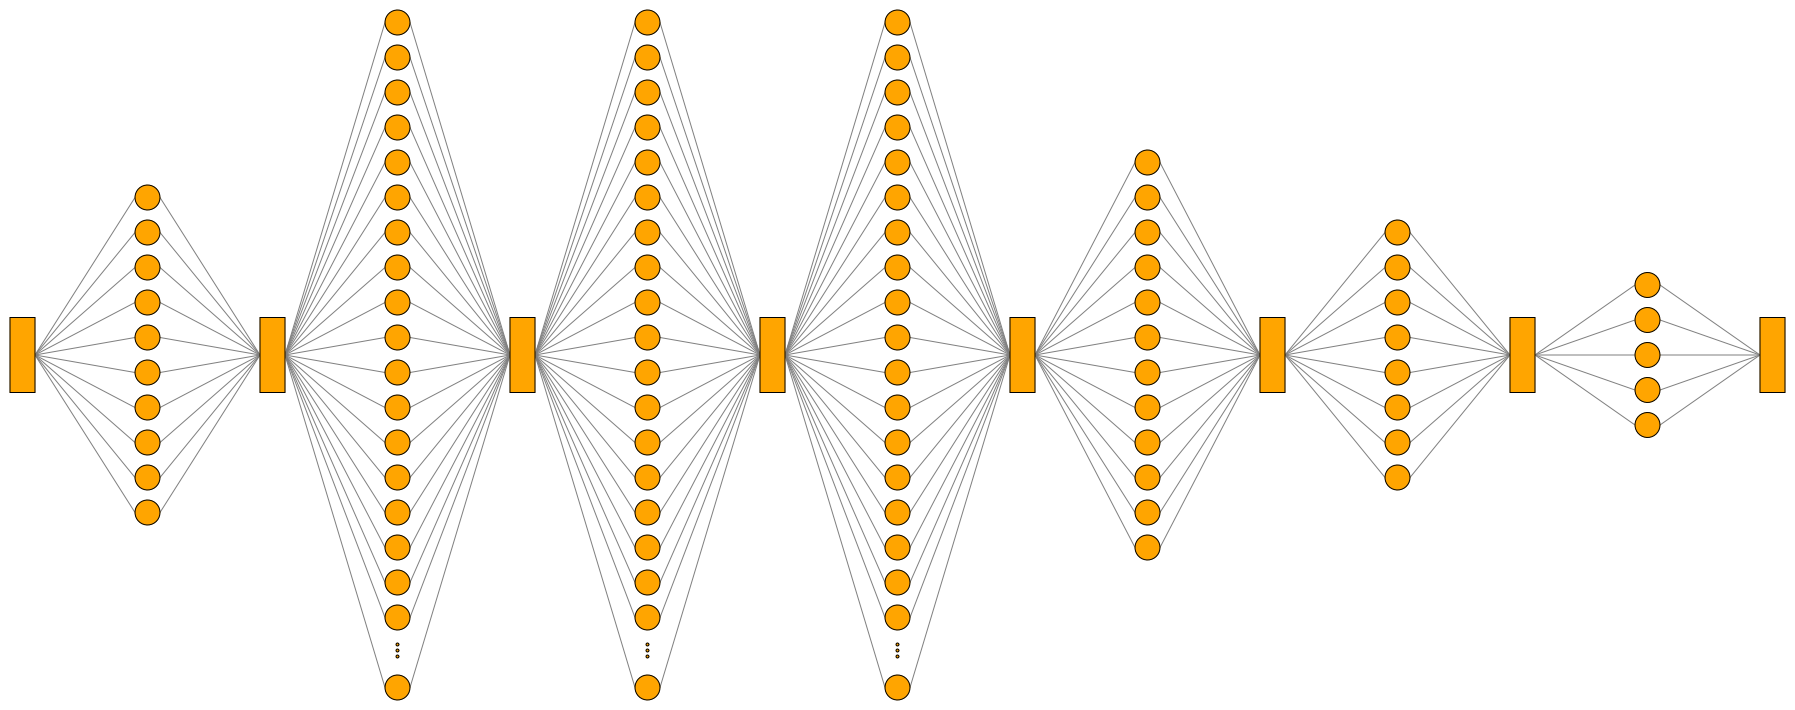

In [44]:
visualkeras.graph_view(model,node_size=25,layer_spacing=100,ellipsize_after=20)

In [45]:
with tf.device('/device:GPU:0'):
    tot_pred = model.predict(dtset.T[:-2].T)

array([1.1773541e-01, 6.9621617e-01, 9.5387943e-02, 9.0637289e-02,
       2.3204713e-05], dtype=float32)

In [19]:
pred_set = dtset.copy()
pred_set['pred'] = tot_pred

In [20]:
cor_pred = len(pred_set[train_len:][pred_set['pred'] >= 0.5][pred_set['tag'] == 1]) + len(pred_set[train_len:][pred_set['pred'] < 0.5][pred_set['tag'] == 0])
print('The accuracy of the test set is : ',cor_pred/(len(pred_set[train_len:])))

/tmp/ipykernel_200/1394875520.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cor_pred = len(pred_set[train_len:][pred_set['pred'] >= 0.5][pred_set['tag'] == 1]) + len(pred_set[train_len:][pred_set['pred'] < 0.5][pred_set['tag'] == 0])


The accuracy of the test set is :  0.8574454040855283


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
print('Correctly identified signal (True Positive)     : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1]))
print('Falsely identified signal (Flase Positive)      : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0]))
print('Correctly identified background (True Negative) : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 0]))
print('Falsely identified background (False Negative)  : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 1]))

Correctly identified signal (True Positive)     :  403827
Falsely identified signal (Flase Positive)      :  2196
Correctly identified background (True Negative) :  2056890
Falsely identified background (False Negative)  :  407950


In [23]:
print('The amount of signal left is     :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/len(df[-1]))
print('The amount of background left is :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0])/np.sum([len(i) for i in df[:-1]]))

The amount of signal left is     : 0.4772720020328206
The amount of background left is : 0.0008947652565421561


In [24]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= 0.5][dtset['tag'] == 1])/(len(pred_set[pred_set['pred'] >= 0.5])))

Thus, the rate of correct signal prediction is :  0.9945914394012162


In [25]:
L = 3000

In [26]:
ns = cs_corr['n2n2']*(len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/(1e6))*L
print('n2n2',cs_corr['n2n2'],(len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])))
nb = 0

for i in range(len(files)-1):
    nb += cs_corr[files[i]]*(len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0][pred_set['type'] == i])/((1e6)))*L
    print(files[i],len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0][pred_set['type'] == i]),cs_corr[files[i]])

n2n2 0.399 403827
ttbar 49 2843.169547246376
wmp 146 30109.0909090909
wpwm 945 212.66363100320171
zwpm 1056 61.44480294117646


In [28]:
print('The number of signal is :', ns)
print('The number of background is :', nb)
print('The significance is :',ns/np.sqrt(nb))

The number of signal is : 483.380919
The number of background is : 14403.286271238756
The significance is : 4.027714762218747


In [29]:
df[2].head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
0,136.238,-1.427660,300.323,129.439,0.128849,131.679,17.4703,60.5694,0.661161,1.593140,120.812,0.065091,0.234445,0.000000,0.540246,25.6794,0.01788,2,0
1,177.032,1.327030,357.172,174.278,0.793436,233.272,23.5985,143.2140,2.138230,0.725024,815.576,0.417532,0.721365,0.505062,0.539998,123.9500,1.49283,2,0
2,207.788,1.245000,390.733,496.299,1.046030,797.173,76.4529,850.1020,2.101450,0.771494,1909.770,0.218092,0.368900,0.271128,0.504858,297.6910,1.82430,2,0
3,153.798,0.165185,155.901,391.888,-0.474061,437.114,17.7209,769.6290,2.880610,1.343040,727.674,0.000000,0.209790,0.383100,0.394240,398.0360,1.15835,2,0
4,163.467,0.292749,170.522,231.087,-0.338531,245.678,24.4810,205.6740,2.039720,0.758088,115.665,0.020697,0.095246,0.163543,0.641187,208.3450,2.38173,2,0


In [30]:
model.save('/home/blizzard/Datasets/Models/s4')

2022-03-26 13:38:59.665958: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/blizzard/Datasets/Models/s4/assets
